In [1]:
# Imports
import numpy as np
import cv2
from matplotlib import pyplot as plt


Scene Image


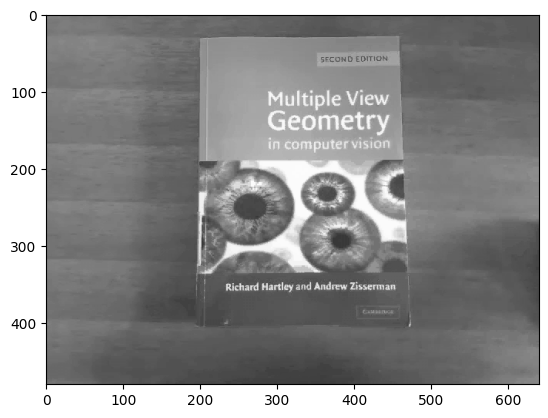

Query Image


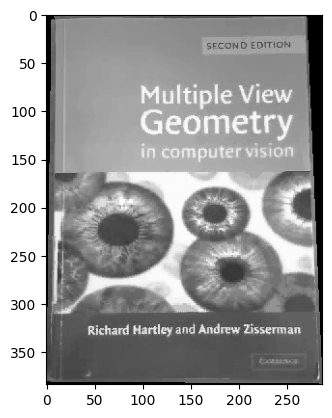

Image to Project


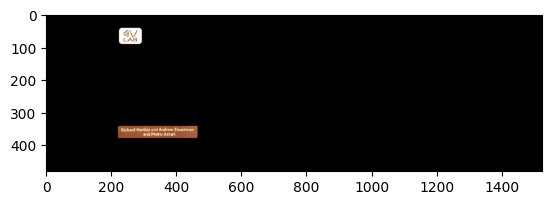

In [2]:
# Load and display images
ref_image = cv2.imread("./ReferenceFrame.png",0)
ar_image = cv2.imread("./AugmentedLayer.png")
mask_image = cv2.imread("./ObjectMask.png",0)

# Apply binary thresholding to the grayscale mask image to create a binary mask
_, binary_mask = cv2.threshold(mask_image, 1, 255, cv2.THRESH_BINARY)
# Apply the binary mask to the reference image
query_image = cv2.bitwise_and(ref_image, ref_image, mask=binary_mask)
# Remove the black countours
contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Crop the query image
x,y,w,h = cv2.boundingRect(contours[0])
query_image = query_image[y:y+h, x:x+w]

print("Scene Image")
plt.imshow(ref_image, 'gray', vmin=0, vmax=255)
plt.show()
print("Query Image")
plt.imshow(query_image, 'gray', vmin=0, vmax=255)
plt.show()
print("Image to Project")
plt.imshow(ar_image, 'gray', vmin=0, vmax=255)
plt.show()


## ORB Version

In [6]:
# Crea un detector per identificare l'oggetto di riferimento nell'immagine di query
detector = cv2.ORB_create()
kp1, des1 = detector.detectAndCompute(ref_image, None)
kp2, des2 = detector.detectAndCompute(query_image, None)

# Trova le corrispondenze tra i descrittori
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x:x.distance)

# Seleziona solo i primi N matches
N = 10
matches = matches[:N]

# Estrai i punti corrispondenti nell'immagine di riferimento e nell'immagine di query
pts_ref = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
pts_query = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# Calcola la matrice di trasformazione che trasforma l'immagine di riferimento nell'immagine di query
M, mask = cv2.findHomography(pts_ref, pts_query, cv2.RANSAC, 5.0)

# Carica l'immagine di realtà aumentata e trasformala in base alla matrice di trasformazione trovata
h, w, channels = ar_image.shape
ar_image_warped = cv2.warpPerspective(ar_image, M, (query_image.shape[1], query_image.shape[0]))
ar_image_warped = cv2.resize(ar_image_warped, (query_image.shape[1], query_image.shape[0]))
print(query_image.shape)
print(ar_image_warped.shape)

# Sovrappone l'immagine di realtà aumentata all'immagine di query
query_image_with_ar = cv2.addWeighted(query_image, 1, ar_image_warped, 0.5, 0)

# Visualizza l'immagine di query con l'immagine di realtà aumentata sovrapposta
plt.imshow(cv2.cvtColor(query_image_with_ar, cv2.COLOR_BGR2RGB))
plt.show()


(480, 640)
(480, 640, 3)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


## SIFT Version

In [3]:
# Create the SIFT detector
sift = cv2.SIFT_create()

# Detect the keypoints and descriptors in the query and reference images
query_keypoints, query_descriptors = sift.detectAndCompute(query_image, None)
ref_keypoints, ref_descriptors = sift.detectAndCompute(ref_image, None)

# Create the FLANN matcher
matcher = cv2.FlannBasedMatcher()

# Match the descriptors between the query and reference images
matches = matcher.knnMatch(query_descriptors, ref_descriptors, k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
# If we have at least 50 matches we find the box of the object
MIN_MATCH_COUNT = 50
if len(good)>MIN_MATCH_COUNT:
    
    # Extract the corresponding keypoints from the query and reference images
    query_points = np.float32([query_keypoints[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    ref_points = np.float32([ref_keypoints[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Calculate the perspective transformation matrix using the corresponding keypoints
    M, mask = cv2.findHomography(ref_points, query_points, cv2.RANSAC, 5.0)

    # Warp the AR image based on the transformation matrix
    ar_image_warped = cv2.warpPerspective(ar_image, M, (query_image.shape[1], query_image.shape[0]))

    # Overlay the augmented reality image onto the query image
    query_image_with_ar = cv2.addWeighted(query_image, 1, ar_image_warped, 0.5, 0)

    # Show the images
    plt.subplot(1, 3, 1), plt.imshow(query_image, cmap='gray')
    plt.title('Query Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 3, 2), plt.imshow(ref_image, cmap='gray')
    plt.title('Reference Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1, 3, 3), plt.imshow(query_image_with_ar, cmap='gray')
    plt.title('Query Image with AR'), plt.xticks([]), plt.yticks([])
    plt.show()


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


## Video AR

### F2R (Frame 2 Reference)

In [5]:
# Open the video capture
cap = cv2.VideoCapture('Multiple View.avi')

while True:
    # Read the current frame
    ret, frame = cap.read()
    
    if not ret: # if the frame is not read successfully
        break
        
    # Convert the frame to grayscale
    query_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect the keypoints and descriptors in the query image
    query_keypoints, query_descriptors = sift.detectAndCompute(query_image, None)

    # Match the descriptors between the query and reference images
    matches = matcher.knnMatch(query_descriptors, ref_descriptors, k=2)

    # Keeping only good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
        
    # If we have at least 50 matches we find the box of the object
    MIN_MATCH_COUNT = 50
    if len(good)>MIN_MATCH_COUNT:

        # Extract the corresponding keypoints from the query and reference images
        query_points = np.float32([query_keypoints[match.queryIdx].pt for match in good]).reshape(-1, 1, 2)
        ref_points = np.float32([ref_keypoints[match.trainIdx].pt for match in good]).reshape(-1, 1, 2)

        # Calculate the perspective transformation matrix using the corresponding keypoints
        M, mask = cv2.findHomography(ref_points, query_points, cv2.RANSAC, 5.0)

        # Warp the augmented reality image based on the transformation matrix
        ar_image_warped = cv2.warpPerspective(ar_image, M, (query_image.shape[1], query_image.shape[0]))

        # Overlay the augmented reality image onto the query image
        query_image_with_ar = cv2.addWeighted(frame, 1, ar_image_warped, 0.5, 0)

        # Display the resulting image
        cv2.imshow('AR Overlay', query_image_with_ar)
    
        # Exit if the 'q' key is pressed
        if cv2.waitKey(1) == ord('q'):
            break

# Release the video capture and destroy all windows
cap.release()
cv2.destroyAllWindows()

### F2F (Frame 2 Frame)

In [5]:
cv2.destroyAllWindows()
# Open the video capture
cap = cv2.VideoCapture('Multiple View.avi')
matrix = np.identity(3) #matrix to multiply for each cycle

while True:
    # Read the current frame
    ret, frame = cap.read()
    
    if not ret: # if the frame is not read successfully
        break
        
    # Convert the frame to grayscale
    query_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect the keypoints and descriptors in the query image
    query_keypoints, query_descriptors = sift.detectAndCompute(query_image, None)

    # Match the descriptors between the query and reference images
    matches = matcher.knnMatch(query_descriptors, ref_descriptors, k=2)

    # Keeping only good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
        
    # If we have at least 50 matches we find the box of the object
    MIN_MATCH_COUNT = 4
    if len(good)>MIN_MATCH_COUNT:

        # Extract the corresponding keypoints from the query and reference images
        query_points = np.float32([query_keypoints[match.queryIdx].pt for match in good]).reshape(-1, 1, 2)
        ref_points = np.float32([ref_keypoints[match.trainIdx].pt for match in good]).reshape(-1, 1, 2)

        # Calculate the perspective transformation matrix using the corresponding keypoints
        M, mask = cv2.findHomography(ref_points, query_points, cv2.RANSAC, 5.0)
        M = np.dot(M, matrix)

        # Warp the augmented reality image based on the transformation matrix
        ar_image_warped = cv2.warpPerspective(ar_image, M, (query_image.shape[1], query_image.shape[0]))

        # Overlay the augmented reality image onto the query image
        query_image_with_ar = cv2.addWeighted(frame, 1, ar_image_warped, 0.5, 0)

        # Display the resulting image
        cv2.imshow('AR Overlay', query_image_with_ar)
        
        # Save current Frame as new Reference image (F 2 F)
        ref_image = query_image
        ref_keypoints, ref_descriptors = sift.detectAndCompute(ref_image, None)
        # Save current M as matrix for the next cycle
        matrix = M
    
        # Exit if the 'q' key is pressed
        if cv2.waitKey(1) == ord('q'):
            break

# Release the video capture and destroy all windows
cap.release()
cv2.destroyAllWindows()

## Old  code

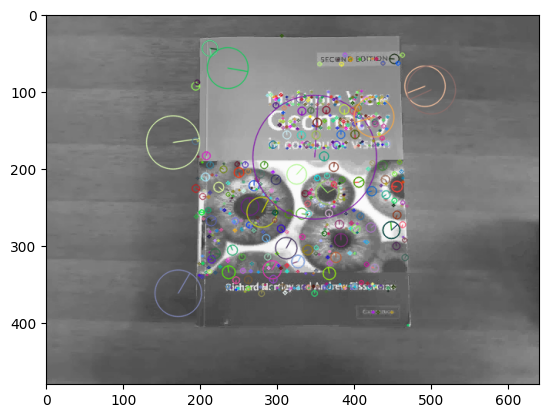

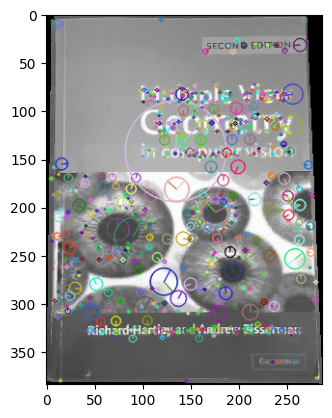

In [13]:
# Implementing the object detection pipeline
#Creating SIFT Object
sift = cv2.SIFT_create()
# Get descriptors and keypoints
query_keypoints, query_descriptors = sift.detectAndCompute(query_image, None)
ref_keypoints, ref_descriptors = sift.detectAndCompute(ref_image, None)

# Visualizing the found Keypoints
img_visualization = cv2.drawKeypoints(ref_image,ref_keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

img_visualization = cv2.drawKeypoints(query_image,query_keypoints,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

In [15]:
# Computing the descriptors for each keypoint
kp_query, des_query = sift.compute(query_image, query_keypoints)
kp_train, des_train = sift.compute(ref_image, ref_keypoints)

# Initializing the matching algorithm
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching the descriptors
matches = flann.knnMatch(query_descriptors, ref_descriptors, k=2)

# Keeping only good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

[[[190  26]]

 [[190 409]]

 [[477 410]]

 [[477  25]]]


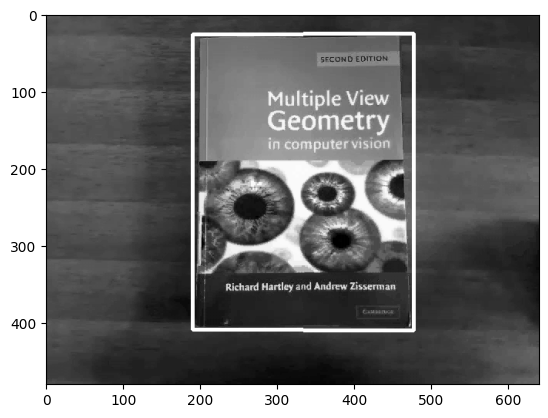

In [17]:
# If we have at least 50 matches we find the box of the object
MIN_MATCH_COUNT = 50
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Matches mask for visualization of only matches used by RANSAC
    matchesMask = mask.ravel().tolist()

    # Apply homography to project corners of the query image into the image
    h,w = query_image.shape
    pts = np.float32([ [0,0],[0,h],[w,h],[w,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    print(np.int32(dst))
    
    # Drawing bounding box
    img2 = cv2.polylines(ref_image,[np.int32(dst)],True,(255,0,255), 3)
    plt.imshow(img2, 'gray')
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


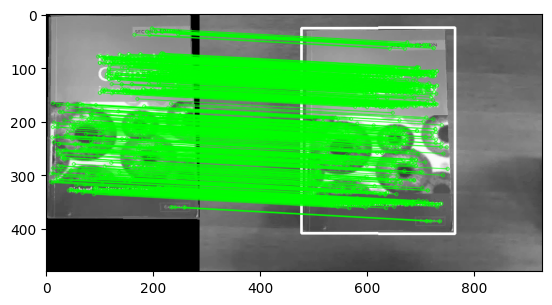

In [18]:
# Drawing matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(query_image,query_keypoints,ref_image,ref_keypoints,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

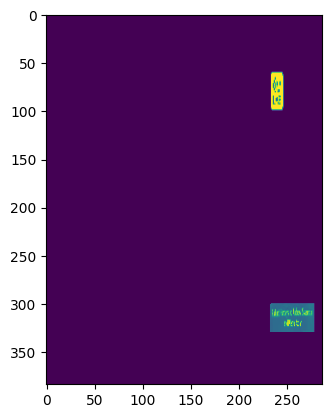

Result Image


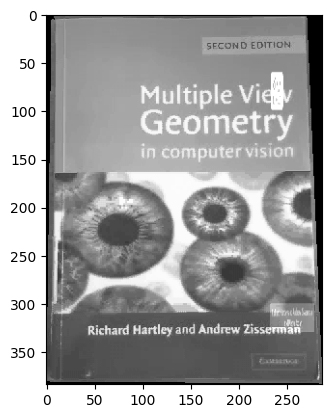

In [20]:
# AR part
h_q, w_q = query_image.shape
h_ar = ar_image.shape[0] 
w_ar = ar_image.shape[1]

# Getting the homography to project img_ar on the surface of the query object.
# Homography already found in previous code with M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
pts_ar = np.float32([ [0,0],[0,h_ar-1],[w_ar-1,h_ar-1],[w_ar-1,0] ]).reshape(-1,1,2)
M = cv2.getPerspectiveTransform(pts_ar,dst)

# Warping the img_ar
warped = cv2.warpPerspective(ar_image, M, (w_q, h_q))
plt.imshow(warped)
plt.show()

# Apply warped image on the query image
query_image_with_ar = cv2.addWeighted(query_image, 1, warped, 0.5, 0)

# Displaying the result
print("Result Image")
plt.imshow(query_image_with_ar,'gray',vmin=0,vmax=255)
plt.show()
